# KZ NOTE:

    Semi-auto-encoder: return the last layer latent space as compressed dv
    
# some notes:
    compressed_dv_semi_ae-v1: ResMLP with output activation. looks ok but maybe more easily interpretable if no output activation
    
    compressed_dv_semi_ae-v2: MLP and NO output activation: this is turns out to be kind of bad
    
    v3: try ResMLP without output activation (not as good as v1). Now v3 is v1 but smaller batch size

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

from compression_nn.preprocess import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16 #
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

In [6]:
# use only labels OMM, S8, A_IA

pars_train = pars_train[:, [0,1,3]]
pars_LFI = pars_LFI[:, [0,1,3]]



# Process data; with ZCA whitening

In [7]:
from compression_nn.preprocess import MinMaxNormalizer

In [8]:
print('Train with all 16 parameters.')

print('max-min normalize the labels')

# Initialize and fit normalizer
label_normalizer = MinMaxNormalizer()
pars_train = label_normalizer.fit_transform(pars_train)


Train with all 16 parameters.
max-min normalize the labels


In [9]:
num_samples = len(pars_train)
indices = np.random.permutation(num_samples)
train_size = int(0.9 * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices],
    train_y=pars_train[train_indices],
    val_x=dv[val_indices],
    val_y=pars_train[val_indices],
    test_x=dv_LFI,
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening=True
)

In [10]:
train_loader

# Start Training!

In [11]:
hyperparameter_configs = [
    {
        'test_id': 'semi_ae_v1',
        'hidden_dims': [128, 64, 32, 16],
        'dropout_rate': 0.2
    },
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.Softplus(),
        arch_name = 'ResMLP'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=50,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [04:51<04:14,  1.90s/it]

Epoch 166/300:
Training Loss: 0.062947
Validation Loss: 0.060856


 60%|██████    | 181/300 [05:19<03:44,  1.89s/it]

Epoch 181/300:
Training Loss: 0.063424
Validation Loss: 0.062285


 65%|██████▌   | 196/300 [05:52<03:58,  2.29s/it]

Epoch 196/300:
Training Loss: 0.062703
Validation Loss: 0.064563


 70%|███████   | 211/300 [06:27<03:28,  2.34s/it]

Epoch 211/300:
Training Loss: 0.062442
Validation Loss: 0.062319


 75%|███████▌  | 226/300 [07:02<02:52,  2.32s/it]

Epoch 226/300:
Training Loss: 0.062626
Validation Loss: 0.062886


 80%|████████  | 241/300 [07:37<02:21,  2.40s/it]

Epoch 241/300:
Training Loss: 0.062986
Validation Loss: 0.062355


 85%|████████▌ | 256/300 [08:11<01:40,  2.30s/it]

Epoch 256/300:
Training Loss: 0.063416
Validation Loss: 0.059935


 89%|████████▉ | 268/300 [08:40<01:02,  1.94s/it]

Early stopping triggered after 269 epochs
Best validation loss is 0.05946846926135236
Model and preprocessing saved to models/model_semi_ae_v1.pkl


# plot validations

In [12]:
from compression_nn.utils import plot_test_error

In [13]:
def plot_test_error_all_param_TEST(model, test_loader, n_params, label_normalizer=None, device='cuda', output=False, out_name='test', Y_min=0, Y_max=1, color='steelblue'):

    g=range(n_params)

    test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    points = 0

    ## Model performance metrics on test set
    num_maps=test_loader.dataset.tensors[0].shape[0]

    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

    # model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            if x.dtype == torch.float64:
                x = x.float()
            x     = x.to(device)       #send data to device
            y     = y.to(device)  #send data to device
            p     = model.predict(x)           #prediction for mean and variance
            y_NN  = p           #prediction for mean

            # save results to their corresponding arrays
            params_true[points:points+x.shape[0]] = y.cpu().numpy()
            if isinstance(y_NN, torch.Tensor):
                y_NN = y_NN.cpu().numpy()
            params_NN[points:points+x.shape[0]]   = y_NN

            points    += x.shape[0]
            
    # inverse-normalization if needed
    if label_normalizer is not None:
        params_NN   = label_normalizer.inverse_transform(params_NN)

    test_error = 100*np.mean(np.sqrt((params_true - params_NN)**2)/params_true,axis=0)
    
    RMSE = np.sqrt(np.mean((params_true - params_NN)**2,axis=0))
    RMSE_P = RMSE*100
    params_true_mean = np.mean(params_true)
    tmp = np.mean((params_true - params_true_mean)**2, axis=0)
    R2 = 1 - (RMSE)**2 / tmp
    # print('Error Omega_m = %.3f'%test_error[0])
    print(r' RMSE = %.3f'%RMSE[0])
    print(r' $R^2$ = %.3f'%R2[0])
    print('Error S_8 = %.3f'%test_error[0])


    # KZ: let me first assume n_params is even 
    f, axarr = plt.subplots(1, 3, figsize=(20,10))
    
    for i in range(n_params):
        # if i%2==0:
        row_idx = i
        print('test', i)
        axarr[row_idx].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

        axarr[row_idx].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
        axarr[row_idx].set_xlabel(r"True param "+str(i))
        axarr[row_idx].set_ylabel(r"Predicted param "+ str(i))

        axarr[row_idx].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx].transAxes)
        axarr[row_idx].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx].transAxes)

#         else:
#             row_idx = i//2
            
#             axarr[row_idx,1].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

#             axarr[row_idx,1].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
#             axarr[row_idx,1].set_xlabel(r"True param "+str(i))
#             axarr[row_idx,1].set_ylabel(r"Predicted param "+ str(i))

#             axarr[row_idx,1].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
#             axarr[row_idx,1].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
            
    if output:
        f.savefig('./output/'+out_name+'.pdf', dpi=300, format='pdf')

        # Also save for LFI later
        info = dict()
        info['params'] = params_true
        info['compressed_DV'] = params_NN
        np.save('./output/'+out_name+'_compressed_dv',info)

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.056
 $R^2$ = 0.937
Error S_8 = 8.463
test 0
test 1
test 2


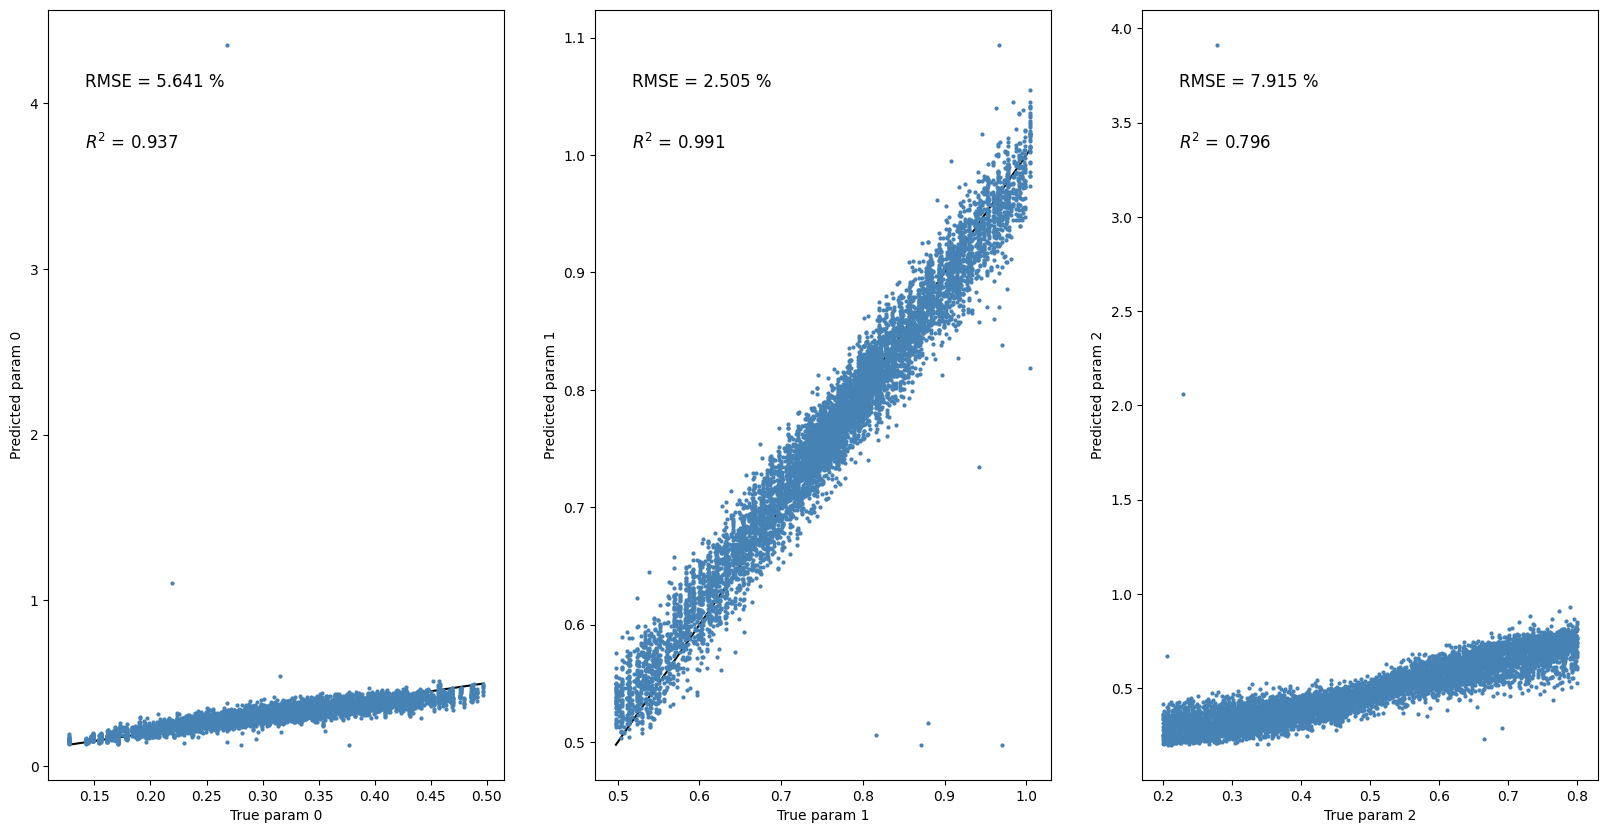

In [14]:
loaded_model = CompressionNN.load('semi_ae_v1')
loaded_model.model.to('cpu')

plot_test_error_all_param_TEST(loaded_model, test_loader, n_params=3, label_normalizer=label_normalizer, device='cpu', output=False)


In [15]:
test_full_dv = test_loader.dataset.tensors[0]
print(test_full_dv.shape)

torch.Size([8187, 608])


In [16]:
compressed_dv_semi_ae = loaded_model.get_last_hidden_layer(test_full_dv)


(-20.0, 10.0)

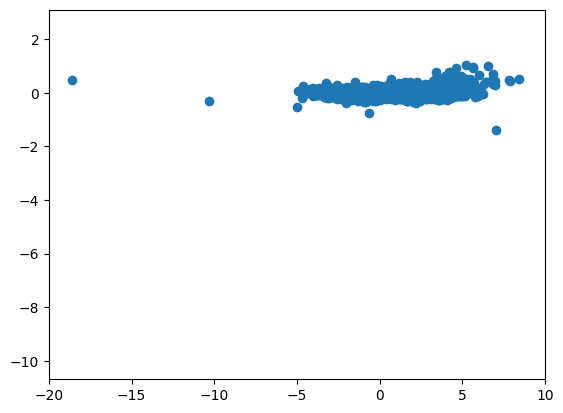

In [17]:
plt.scatter(compressed_dv_semi_ae[:,2], compressed_dv_semi_ae[:,3])
plt.xlim(-20,10)

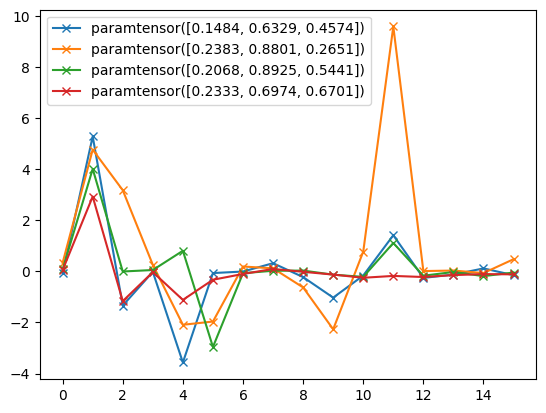

In [18]:
for i in [1,5,200,100]:
    plt.plot(compressed_dv_semi_ae[i], 'x-', label='param'+str(test_loader.dataset.tensors[1][i]))
    
plt.legend()

# Test at fiducial cosmology

In [19]:
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()

dv_set_fid = derivatives_dict['WL_23_WPH_WCMBL_CMBL']['cov'][:,indict2['WL_23_WPH_short_CMBWL'] ]

dv_compressed_fid = loaded_model.predict(dv_set_fid)
dv_compressed_fid = label_normalizer.inverse_transform(dv_compressed_fid)

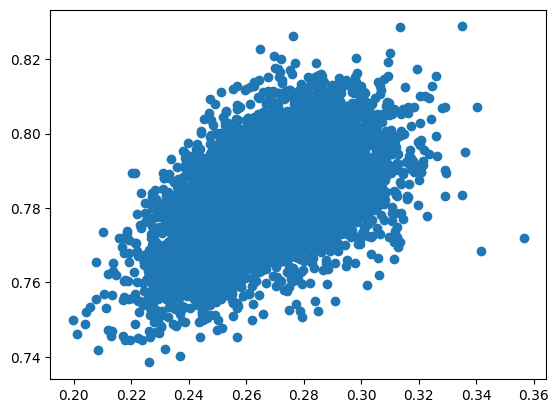

In [20]:
plt.scatter(dv_compressed_fid[:,0], dv_compressed_fid[:,1])

In [21]:
target_compressed_dv = np.mean(dv_compressed_fid, axis=0)

In [22]:
dv_compressed_fid_ae = loaded_model.get_last_hidden_layer(dv_set_fid)
dv_compressed_fid_ae = np.mean(dv_compressed_fid_ae,axis=0)

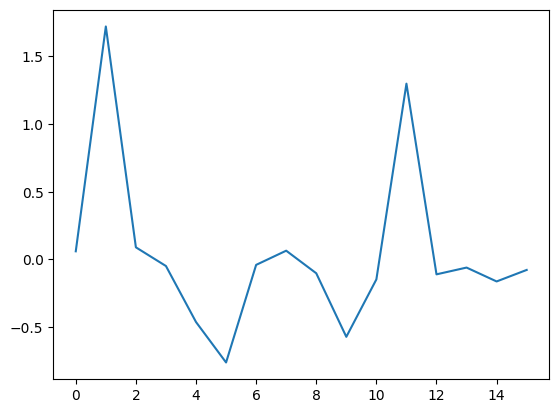

In [23]:

plt.plot(dv_compressed_fid_ae)

In [24]:
compressed_dv_semi_ae.shape, dv_compressed_fid_ae.shape

((8187, 16), (16,))

In [25]:
np.save('./output/compressed_dv_semi_ae_v1', compressed_dv_semi_ae)
np.save('./output/dv_compressed_fid_ae_v1', dv_compressed_fid_ae)